# Les Noyaux (Kernels) en Machine Learning
### Master 2 Banque Finance Assurance — Paris Dauphine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, roc_curve, confusion_matrix)
from sklearn.datasets import make_circles, make_moons

np.random.seed(42)

---
# Partie 1 — Cours & Visualisation

## 1.1 — Motivation : pourquoi quitter R² ?

En classification, la régression logistique cherche une **frontière linéaire** : un hyperplan qui sépare les classes.

$$P(y=1 | x) = \sigma(w^\top x + b) = \frac{1}{1 + e^{-(w^\top x + b)}}$$

**Problème :** Que se passe-t-il quand les données ne sont pas linéairement séparables ?


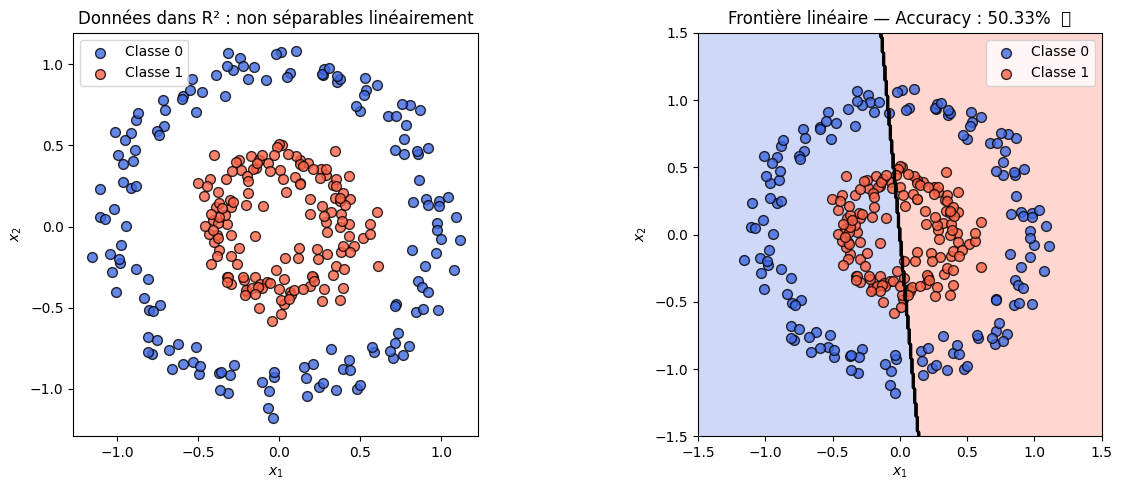

Accuracy régression logistique linéaire : 50.33%


In [2]:
# Données non linéairement séparables en R²
X_2d, y_2d = make_circles(n_samples=300, noise=0.08, factor=0.4, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Scatter des données
ax = axes[0]
ax.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1], c='royalblue', edgecolors='k',
           s=50, alpha=0.8, label='Classe 0')
ax.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1], c='tomato', edgecolors='k',
           s=50, alpha=0.8, label='Classe 1')
ax.set_title("Données dans R² : non séparables linéairement", fontsize=12)
ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
ax.legend(); ax.set_aspect('equal')

# Tentative de séparateur linéaire
ax2 = axes[1]
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 300), np.linspace(-1.5, 1.5, 300))
X_grid = np.c_[xx.ravel(), yy.ravel()]

clf_lin = LogisticRegression()
clf_lin.fit(X_2d, y_2d)
Z = clf_lin.predict(X_grid).reshape(xx.shape)

ax2.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(['royalblue', 'tomato']))
ax2.contour(xx, yy, Z, colors='k', linewidths=1.5)
ax2.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1], c='royalblue',
            edgecolors='k', s=50, alpha=0.8, label='Classe 0')
ax2.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1], c='tomato',
            edgecolors='k', s=50, alpha=0.8, label='Classe 1')
acc = clf_lin.score(X_2d, y_2d)
ax2.set_title(f"Frontière linéaire — Accuracy : {acc:.2%}  ❌", fontsize=12)
ax2.set_xlabel("$x_1$"); ax2.set_ylabel("$x_2$")
ax2.legend(); ax2.set_aspect('equal')

plt.tight_layout()
plt.savefig('fig1_motivation.png', dpi=120, bbox_inches='tight')
plt.show()
print(f"Accuracy régression logistique linéaire : {acc:.2%}")

## 1.2 — L'idée du plongement : φ explicite de R² dans R³

**Idée clé :** Si les données ne sont pas séparables dans $\mathbb{R}^2$, on les *plonge* dans un espace de plus grande dimension où elles **deviennent** séparables.

Définissons le plongement **φ explicite** suivant :

$$\varphi : \mathbb{R}^2 \rightarrow \mathbb{R}^3$$

$$\varphi(x_1, x_2) = \left(x_1,\ x_2,\ x_1^2 + x_2^2\right)$$

L'intuition : on ajoute une troisième dimension qui est le **rayon au carré** $r^2 = x_1^2 + x_2^2$.

Dans cet espace augmenté, un **hyperplan** (ici un plan horizontal) peut séparer parfaitement les deux cercles !


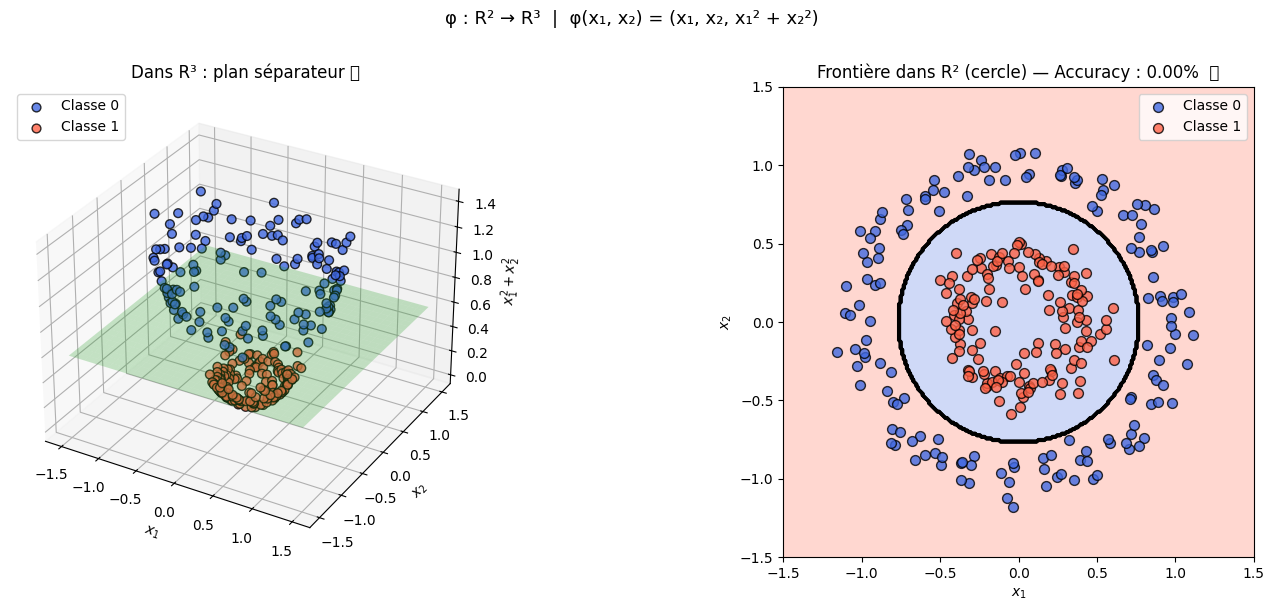

Accuracy avec plongement φ explicite : 0.00%
Seuil de séparation sur z = r² : 0.589


In [5]:
# Application du plongement phi explicite R² -> R³
def phi_explicit(X):
    """Plongement explicite : (x1, x2) -> (x1, x2, x1² + x2²)"""
    x1, x2 = X[:, 0], X[:, 1]
    return np.column_stack([x1, x2, x1**2 + x2**2])

X_3d = phi_explicit(X_2d)

fig = plt.figure(figsize=(16, 6))

# Vue 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_3d[y_2d==0, 0], X_3d[y_2d==0, 1], X_3d[y_2d==0, 2],
            c='royalblue', edgecolors='k', s=40, alpha=0.8, label='Classe 0')
ax1.scatter(X_3d[y_2d==1, 0], X_3d[y_2d==1, 1], X_3d[y_2d==1, 2],
            c='tomato', edgecolors='k', s=40, alpha=0.8, label='Classe 1')

# Plan séparateur horizontal
x1_surf = np.linspace(-1.5, 1.5, 30)
x2_surf = np.linspace(-1.5, 1.5, 30)
X1S, X2S = np.meshgrid(x1_surf, x2_surf)
# Trouver le seuil optimal (entre les deux classes sur l'axe z)
z_class0 = X_3d[y_2d==0, 2].mean()
z_class1 = X_3d[y_2d==1, 2].mean()
z_sep = (z_class0 + z_class1) / 2
ZS = np.full_like(X1S, z_sep)

ax1.plot_surface(X1S, X2S, ZS, alpha=0.25, color='limegreen')
ax1.set_xlabel("$x_1$"); ax1.set_ylabel("$x_2$"); ax1.set_zlabel("$x_1^2 + x_2^2$")
ax1.set_title("Dans R³ : plan séparateur ✅", fontsize=12)
ax1.legend(loc='upper left')

# Projection retour en R² : la frontière est un cercle !
ax2 = fig.add_subplot(122)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 300), np.linspace(-1.5, 1.5, 300))
X_grid_2d = np.c_[xx.ravel(), yy.ravel()]
X_grid_3d = phi_explicit(X_grid_2d)

# Frontière = là où x1² + x2² = z_sep
Z_proj = (X_grid_3d[:, 2] > z_sep).astype(int).reshape(xx.shape)

ax2.contourf(xx, yy, Z_proj, alpha=0.25, cmap=ListedColormap(['royalblue', 'tomato']))
ax2.contour(xx, yy, Z_proj, colors='k', linewidths=2)
ax2.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1], c='royalblue',
            edgecolors='k', s=50, alpha=0.8, label='Classe 0')
ax2.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1], c='tomato',
            edgecolors='k', s=50, alpha=0.8, label='Classe 1')

y_pred_3d = (X_3d[:, 2] > z_sep).astype(int)
acc_3d = accuracy_score(y_2d, y_pred_3d)
ax2.set_title(f"Frontière dans R² (cercle) — Accuracy : {acc_3d:.2%}  ✅", fontsize=12)
ax2.set_xlabel("$x_1$"); ax2.set_ylabel("$x_2$")
ax2.legend(); ax2.set_aspect('equal')

plt.suptitle("φ : R² → R³  |  φ(x₁, x₂) = (x₁, x₂, x₁² + x₂²)", fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('fig2_plongement.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"Accuracy avec plongement φ explicite : {acc_3d:.2%}")
print(f"Seuil de séparation sur z = r² : {z_sep:.3f}")

## 1.3 — Du φ explicite au Kernel : le lien fondamental

Le plongement φ explicite fonctionne, mais il a un **défaut majeur** :  
pour des φ complexes (degré élevé, haute dimension), calculer φ(x) explicitement devient **très coûteux**, voire infini.

**L'idée du kernel :** La plupart des algorithmes (dont la régression logistique régularisée) n'ont besoin que de **produits scalaires** entre points transformés :

$$k(x, x') = \langle \varphi(x),\, \varphi(x') \rangle$$

On peut calculer ce produit scalaire **directement**, sans jamais calculer φ !

---

### Exemple : le kernel polynomial de degré 2

Prenons $x = (x_1, x_2) \in \mathbb{R}^2$ et le plongement :

$$\varphi(x) = (x_1^2,\ x_2^2,\ \sqrt{2}\, x_1 x_2,\ \sqrt{2c}\, x_1,\ \sqrt{2c}\, x_2,\ c)$$

Alors :

$$\langle \varphi(x), \varphi(x') \rangle = (x^\top x' + c)^2 = k(x, x')$$

Le kernel polynomial **encapsule** un plongement en dimension 6 dans $\mathbb{R}^2$, sans jamais le calculer !


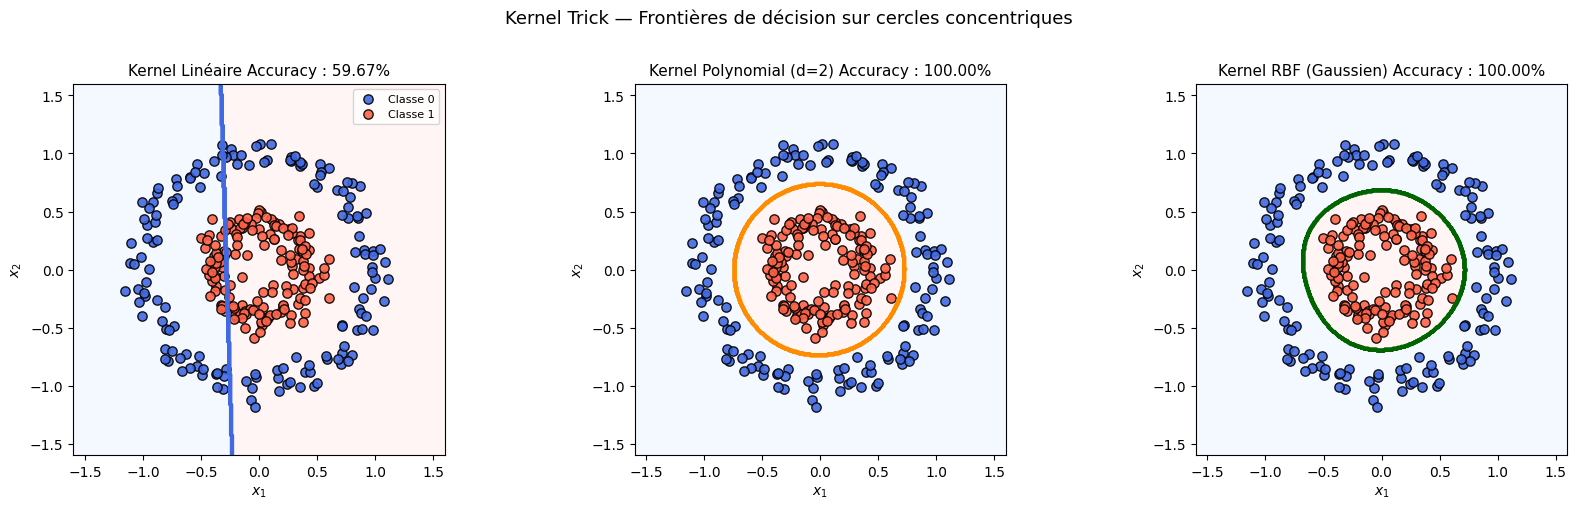

Récapitulatif des accuracies :
  Linéaire                  : 59.67%
  Polynomial (d=2)          : 100.00%
  RBF (Gaussien)            : 100.00%


In [16]:
# Kernel Trick : comparaison visuelle sur cercles concentriques
# Logistique linéaire vs SVM avec kernel RBF (proxy du kernel trick)

# On utilise SVC avec kernel pour illustrer la frontière non linéaire
# (sklearn n'a pas de KernelLogisticRegression native, mais SVC illustre
#  parfaitement le kernel trick — même principe mathématique)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

kernels = [
    ('linear',  'Linéaire',            'royalblue', {}),
    ('poly',    'Polynomial (d=2)',     'darkorange', {'degree': 2, 'coef0': 1}),
    ('rbf',     'RBF (Gaussien)',       'darkgreen',  {'gamma': 2.0}),
]

xx, yy = np.meshgrid(np.linspace(-1.6, 1.6, 400), np.linspace(-1.6, 1.6, 400))
X_grid = np.c_[xx.ravel(), yy.ravel()]

colors_bg = ['#DDEEFF', '#FFE5E5']
cmap_bg = ListedColormap(colors_bg)

for ax, (kname, ktitle, kcolor, kparams) in zip(axes, kernels):
    clf = SVC(kernel=kname, C=1.0, **kparams)
    clf.fit(X_2d, y_2d)
    Z = clf.predict(X_grid).reshape(xx.shape)
    acc = clf.score(X_2d, y_2d)

    ax.contourf(xx, yy, Z, alpha=0.35, cmap=cmap_bg)
    ax.contour(xx, yy, Z, colors=kcolor, linewidths=2.5)

    ax.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1],
               c='royalblue', edgecolors='k', s=45, alpha=0.9, label='Classe 0')
    ax.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1],
               c='tomato', edgecolors='k', s=45, alpha=0.9, label='Classe 1')

    ax.set_title(f"Kernel {ktitle} Accuracy : {acc:.2%}", fontsize=11)
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.set_aspect('equal')
    if kname == 'linear':
        ax.legend(fontsize=8)

plt.suptitle("Kernel Trick — Frontières de décision sur cercles concentriques",
             fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('fig4_kernel_trick.png', dpi=120, bbox_inches='tight')
plt.show()

print("Récapitulatif des accuracies :")
for kname, ktitle, _, kparams in kernels:
    clf = SVC(kernel=kname, C=1.0, **kparams)
    clf.fit(X_2d, y_2d)
    print(f"  {ktitle:25s} : {clf.score(X_2d, y_2d):.2%}")

### Bilan de la Partie 1

| Concept | Ce qu'il faut retenir |
|---------|----------------------|
| **Plongement φ** | Projeter les données dans un espace de plus grande dimension pour linéariser le problème |
| **Kernel** | Calculer le produit scalaire ⟨φ(x), φ(x')⟩ **sans** calculer φ — c'est le **kernel trick** |
| **Kernel RBF** | Le plus flexible, espace de dimension infinie, γ contrôle la localité |
| **Attention** | Flexibilité ≠ performance : un kernel trop souple sur-apprend ! → régularisation nécessaire |

---


---
# Partie 2 — Exercices Guidés

## De la Régression Logistique Linéaire au Modèle Kernelisé Régularisé

### Contexte : Scoring de Crédit Synthétique

Nous travaillons sur un jeu de données de **scoring de crédit** synthétique.  
Chaque observation est un client bancaire, et nous cherchons à prédire s'il va **faire défaut** (y=1) ou non (y=0).

Les features sont :
- `ratio_endettement` : rapport dette / revenu
- `historique_retards` : score d'historique de paiement

> **Particularité pédagogique :** la relation entre ces features et le défaut est **non linéaire** — ce que nous allons découvrir progressivement.


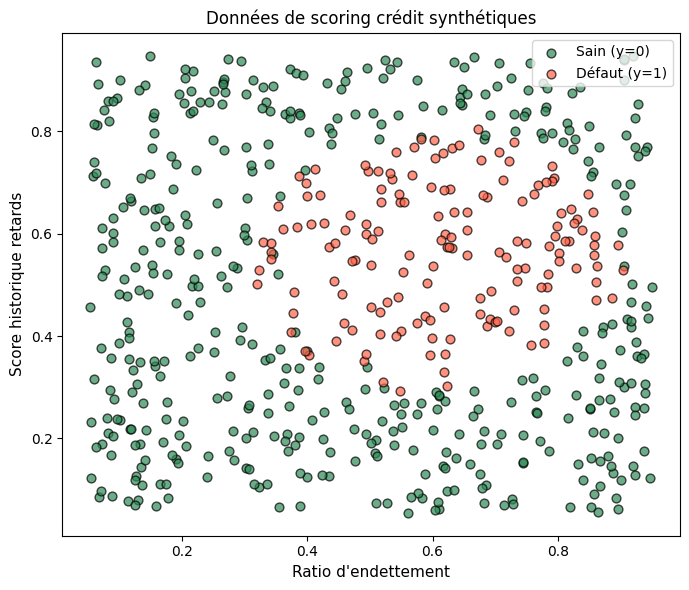

Dataset : 600 clients | 26.2% de défauts
Shape X : (600, 2)


In [9]:
# === Génération des données synthétiques de scoring ===

def generate_credit_data(n=600, noise=0.12, random_state=42):
    """
    Génère des données de crédit synthétiques avec une frontière non linéaire.
    La zone de défaut est elliptique (non linéairement séparable).
    """
    rng = np.random.RandomState(random_state)

    # Feature 1 : ratio d'endettement (0 à 1)
    x1 = rng.uniform(0.05, 0.95, n)
    # Feature 2 : score historique retards (0 = parfait, 1 = mauvais)
    x2 = rng.uniform(0.05, 0.95, n)

    # Frontière vraie : ellipse non centrée
    # défaut si (x1 - 0.6)²/0.08 + (x2 - 0.55)²/0.06 < 1
    ellipse = ((x1 - 0.6)**2 / 0.085) + ((x2 - 0.55)**2 / 0.065)
    prob_defaut = 1 / (1 + np.exp(3 * (ellipse - 1)))  # sigmoïde autour de l'ellipse

    # Ajout de bruit
    prob_defaut += noise * rng.randn(n)
    prob_defaut = np.clip(prob_defaut, 0, 1)
    y = (prob_defaut > 0.5).astype(int)

    X = np.column_stack([x1, x2])
    return X, y

X_credit, y_credit = generate_credit_data(n=600)

# Affichage
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(X_credit[y_credit==0, 0], X_credit[y_credit==0, 1],
           c='seagreen', edgecolors='k', s=40, alpha=0.7, label='Sain (y=0)')
ax.scatter(X_credit[y_credit==1, 0], X_credit[y_credit==1, 1],
           c='tomato', edgecolors='k', s=40, alpha=0.7, label='Défaut (y=1)')
ax.set_xlabel("Ratio d'endettement", fontsize=11)
ax.set_ylabel("Score historique retards", fontsize=11)
ax.set_title("Données de scoring crédit synthétiques", fontsize=12)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('fig5_credit_data.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"Dataset : {X_credit.shape[0]} clients | {y_credit.mean():.1%} de défauts")
print(f"Shape X : {X_credit.shape}")


---
## Exercice 1 — Modèle de base : Régression Logistique Linéaire

In [10]:
# === Exercice 1.1 : Split et standardisation ===

# TODO : Séparez X_credit, y_credit en train (80%) et test (20%)
# Utilisez random_state=42 et stratify=y_credit
X_train, X_test, y_train, y_test = # VOTRE CODE ICI

# TODO : Instanciez un StandardScaler et fittez-le UNIQUEMENT sur le train
scaler = # VOTRE CODE ICI
# TODO : Transformez X_train et X_test
X_train_sc = # VOTRE CODE ICI
X_test_sc  = # VOTRE CODE ICI

print(f"Train : {X_train_sc.shape} | Test : {X_test_sc.shape}")
print(f"Taux de défaut — Train : {y_train.mean():.2%} | Test : {y_test.mean():.2%}")

SyntaxError: invalid syntax (3829705983.py, line 5)

### 1.2 — Entraînement et évaluation du modèle linéaire

In [ ]:
# === Exercice 1.2 : LogReg linéaire ===

# TODO : Entraînez une LogisticRegression avec C=1.0 sur les données standardisées
logit_lin = # VOTRE CODE ICI
# TODO : Calculez l'accuracy sur train et test
acc_train_lin = # VOTRE CODE ICI
acc_test_lin  = # VOTRE CODE ICI

# TODO : Calculez l'AUC-ROC sur le test (utilisez predict_proba)
auc_lin = # VOTRE CODE ICI

print(f"Régression Logistique Linéaire :")
print(f"  Accuracy Train : {acc_train_lin:.4f}")
print(f"  Accuracy Test  : {acc_test_lin:.4f}")
print(f"  AUC-ROC Test   : {auc_lin:.4f}")

---
## Exercice 2 — Modèle Kernelisé : SVM avec Kernel RBF

Sklearn propose `SVC` (Support Vector Classifier) qui implémente nativement le kernel trick.  
On peut voir le SVM comme une régression logistique kernelisée avec une loss différente (hinge vs log).

Les hyperparamètres clés :
- `C` : régularisation (petit C = plus régularisé)
- `gamma` : largeur du kernel RBF ($\gamma$ dans $\exp(-\gamma\|x-x'\|^2)$)
  - `gamma='scale'` → $\gamma = 1 / (n\_features \times \text{Var}(X))$ recommandé

In [11]:
# === Exercice 2.1 : SVM RBF avec paramètres par défaut ===

# TODO : Entraînez un SVC avec kernel='rbf', C=1.0, gamma='scale'
svm_rbf = # VOTRE CODE ICI
svm_rbf.fit(# VOTRE CODE ICI)

# TODO : Calculez accuracy train/test et AUC
acc_train_rbf = # VOTRE CODE ICI
acc_test_rbf  = # VOTRE CODE ICI
auc_rbf = # VOTRE CODE ICI  # Attention : SVC a decision_function, pas predict_proba par défaut
                              # Utilisez probability=True dans SVC pour avoir predict_proba

print(f"SVM Kernel RBF (C=1, gamma='scale') :")
print(f"  Accuracy Train : {acc_train_rbf:.4f}")
print(f"  Accuracy Test  : {acc_test_rbf:.4f}")
print(f"  AUC-ROC Test   : {auc_rbf:.4f}")

SyntaxError: invalid syntax (144341158.py, line 4)

### 2.2 — Visualisation comparée des frontières de décision

NameError: name 'logit_lin' is not defined

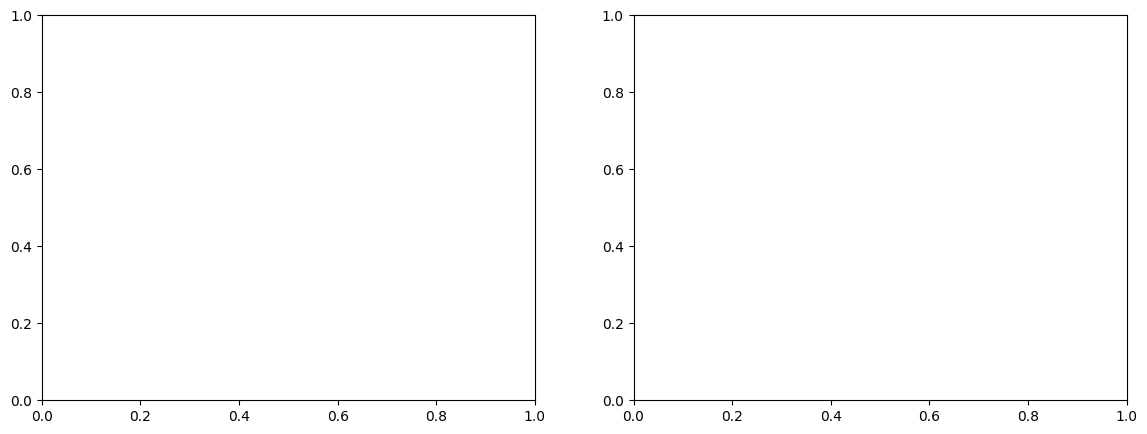

In [12]:
# Visualisation des frontières : Linéaire vs RBF

def plot_decision_boundary(ax, clf, X_sc, y, scaler, title, acc, auc):
    """Trace la frontière de décision dans l'espace original (non standardisé)."""
    x1_min, x1_max = X_credit[:, 0].min() - 0.05, X_credit[:, 0].max() + 0.05
    x2_min, x2_max = X_credit[:, 1].min() - 0.05, X_credit[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                         np.linspace(x2_min, x2_max, 300))
    X_grid_orig = np.c_[xx.ravel(), yy.ravel()]
    X_grid_sc   = scaler.transform(X_grid_orig)

    Z = clf.predict(X_grid_sc).reshape(xx.shape)
    cmap_bg = ListedColormap(['#D5F5E3', '#FADBD8'])
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_bg)
    ax.contour(xx, yy, Z, colors='k', linewidths=2)

    X_orig = scaler.inverse_transform(X_sc)
    ax.scatter(X_orig[y==0, 0], X_orig[y==0, 1], c='seagreen',
               edgecolors='k', s=35, alpha=0.8, label='Sain')
    ax.scatter(X_orig[y==1, 0], X_orig[y==1, 1], c='tomato',
               edgecolors='k', s=35, alpha=0.8, label='Défaut')
    ax.set_xlabel("Ratio d'endettement"); ax.set_ylabel("Score retards")
    ax.set_title(f"{title}\nAcc={acc:.2%} | AUC={auc:.3f}", fontsize=11)
    ax.legend(fontsize=8)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(axes[0], logit_lin, X_test_sc, y_test, scaler,
                       "LogReg Linéaire", acc_test_lin, auc_lin)
plot_decision_boundary(axes[1], svm_rbf, X_test_sc, y_test, scaler,
                       "SVM Kernel RBF", acc_test_rbf, auc_rbf)
plt.suptitle("Comparaison des frontières de décision — Scoring Crédit", fontsize=13)
plt.tight_layout()
plt.savefig('fig6_frontières_credit.png', dpi=120, bbox_inches='tight')
plt.show()

---
## Exercice 3 — Optimisation des Hyperparamètres par Validation Croisée

Le kernel RBF a deux hyperparamètres à régler : **C** et **gamma**.  
On utilise une `GridSearchCV` avec validation croisée 5-fold.

> **Question de réflexion :** Que se passe-t-il si C est très grand et gamma très grand ?  
> Que se passe-t-il si C et gamma sont très petits ?


In [ ]:
# === Exercice 3 : GridSearchCV ===

# TODO : Définissez la grille de paramètres
param_grid = {
    # VOTRE CODE : testez C dans [0.1, 1, 10, 100]
    #              et gamma dans ['scale', 0.1, 1, 10]
}

# TODO : Instanciez un GridSearchCV avec SVC(kernel='rbf', probability=True)
# Utilisez cv=5, scoring='roc_auc', n_jobs=-1
grid_search = # VOTRE CODE ICI

# TODO : Lancez la recherche sur les données d'entraînement
grid_search.fit(# VOTRE CODE ICI)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur AUC-ROC (CV) : {grid_search.best_score_:.4f}")

In [13]:
# Heatmap des résultats de la GridSearch
results = grid_search.cv_results_
gammas = ['scale', 0.1, 1, 10]
Cs     = [0.1, 1, 10, 100]

# Récupérer les scores moyens et les reshaper
scores = results['mean_test_score']
# Construire la matrice manuellement
score_matrix = np.zeros((len(Cs), len(gammas)))
idx = 0
for i, c in enumerate(Cs):
    for j, g in enumerate(gammas):
        # trouver l'entrée correspondante
        mask = (results['param_C'] == c) & (results['param_gamma'] == g)
        if mask.sum() > 0:
            score_matrix[i, j] = results['mean_test_score'][mask][0]

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(score_matrix, aspect='auto', cmap='YlOrRd',
               vmin=score_matrix.min(), vmax=score_matrix.max())
ax.set_xticks(range(len(gammas))); ax.set_xticklabels([str(g) for g in gammas])
ax.set_yticks(range(len(Cs)));    ax.set_yticklabels([str(c) for c in Cs])
ax.set_xlabel("gamma", fontsize=12); ax.set_ylabel("C", fontsize=12)
ax.set_title("AUC-ROC (CV 5-fold) — GridSearch SVM RBF", fontsize=12)
plt.colorbar(im, ax=ax, label='AUC-ROC moyen')

for i in range(len(Cs)):
    for j in range(len(gammas)):
        ax.text(j, i, f"{score_matrix[i,j]:.3f}", ha='center', va='center',
                fontsize=9, color='black' if score_matrix[i,j] < 0.9 else 'white')

plt.tight_layout()
plt.savefig('fig7_gridsearch.png', dpi=120, bbox_inches='tight')
plt.show()

NameError: name 'grid_search' is not defined

---
## Exercice 4 — Bilan comparatif et courbes ROC

### Récapitulatif des modèles testés


In [ ]:
# === Exercice 4 : Bilan et courbes ROC ===

# TODO : Calculez les probabilités prédites pour chaque modèle sur X_test_sc
# Indice : utilisez predict_proba(X_test_sc)[:, 1]
proba_lin  = # VOTRE CODE ICI  (logit_lin)
proba_rbf  = # VOTRE CODE ICI  (svm_rbf)
proba_best = # VOTRE CODE ICI  (best_svm)

# TODO : Calculez les courbes ROC pour chaque modèle
# Indice : roc_curve(y_test, probas) renvoie (fpr, tpr, thresholds)
fpr_lin,  tpr_lin,  _ = # VOTRE CODE ICI
fpr_rbf,  tpr_rbf,  _ = # VOTRE CODE ICI
fpr_best, tpr_best, _ = # VOTRE CODE ICI


### Bilan de la Partie 2

**Ce que vous avez accompli :**
1. Partis d'un modèle linéaire limité (frontière droite sur un problème elliptique)
2. Introduit le kernel RBF pour capturer la non-linéarité
3. Optimisé les hyperparamètres C et γ par validation croisée
4. Mesuré l'amélioration objective avec AUC-ROC

---
# Partie 3 — Projet Libre : Signal Buy/Sell sur Données de Marché

## Contexte

Vous allez construire un **modèle de classification kernelisé** pour générer des signaux de trading sur des données réelles.

**Objectif :** Prédire si le rendement cumulatif sur les **N prochains jours** sera positif (Buy) ou négatif/nul (Sell).

Ce projet est **ouvert** : vous choisissez vos features, votre horizon, votre modèle.

---

## Données disponibles

Les données sont téléchargées via **yfinance**. Vous pouvez choisir n'importe quel actif.


In [14]:
# === Installation et téléchargement des données ===
try:
    import yfinance as yf
    print("yfinance disponible")
except ImportError:
    print("yfinance non installé.")
    print("Lancez : pip install yfinance")
    print("Puis relancez cette cellule.")


yfinance non installé.
Lancez : pip install yfinance
Puis relancez cette cellule.


In [ ]:
# === Téléchargement des données ===
import yfinance as yf
import pandas as pd

# Choix de l'actif — modifiable !
TICKER   = "^GSPC"    # S&P 500  (autres : "^FCHI" CAC40, "AAPL", "BNP.PA"...)
START    = "2015-01-01"
END      = "2024-12-31"
HORIZON  = 10         # horizon de prédiction en jours

data = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
data = data[['Close', 'High', 'Low', 'Volume']].dropna()

print(f"Actif : {TICKER}")
print(f"Période : {data.index[0].date()} → {data.index[-1].date()}")
print(f"Nombre de jours de trading : {len(data)}")
print(f"\nAperçu :\n{data.tail()}")

---
## Étape 1 — Construction des Features

> **À vous de jouer !** Construisez des features pertinentes pour prédire la direction du marché.

Quelques idées (vous n'êtes pas obligés de toutes les utiliser, et vous pouvez en inventer d'autres) :

**Features de momentum / tendance :**
- Returns sur 1, 5, 10, 20 jours
- Momentum : prix actuel / prix il y a N jours

**Features de volatilité :**
- Volatilité réalisée sur fenêtre glissante (std des returns)
- Amplitude High-Low normalisée

**Indicateurs techniques :**
- RSI (Relative Strength Index)
- MACD (Moving Average Convergence Divergence)
- Bandes de Bollinger (z-score du prix)

**Conseil :** commencez simple (2-4 features), évaluez, puis enrichissez.


In [15]:
# === VOTRE CODE : Construction des features ===

df = data.copy()

# --- Returns ---
# TODO : Calculez les returns journaliers et sur différentes fenêtres
df['ret_1d']  = df['Close'].pct_change(1)
# À compléter...

# --- Volatilité ---
# TODO : Calculez la volatilité réalisée sur 10 jours
# df['vol_10d'] = ...

# --- Indicateurs techniques (optionnel) ---
# RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain  = delta.clip(lower=0).rolling(window).mean()
    loss  = (-delta.clip(upper=0)).rolling(window).mean()
    rs    = gain / loss
    return 100 - (100 / (1 + rs))

# df['rsi_14'] = compute_rsi(df['Close'])

# --- Label : return cumulatif sur HORIZON jours > 0 = Buy ---
df['target'] = (df['Close'].shift(-HORIZON) > df['Close']).astype(int)

# Supprimez les NaN
df.dropna(inplace=True)

# Sélectionnez vos features ici
FEATURES = ['ret_1d']  # TODO : enrichir cette liste

X_mkt = df[FEATURES].values
y_mkt = df['target'].values

print(f"Features : {FEATURES}")
print(f"Dataset : {X_mkt.shape[0]} observations | {y_mkt.mean():.1%} de Buy")
print(f"\nAperçu des features :\n{df[FEATURES + ['target']].tail(10)}")

NameError: name 'data' is not defined

---
## Étape 2 — Split Temporel ⚠️

> **Attention critique :** En finance, on ne fait **jamais** un split aléatoire.  
> Le split doit respecter l'ordre temporel pour éviter le **data leakage**.

$$\text{Train} = \{t \leq T_{split}\} \quad \text{Test} = \{t > T_{split}\}$$


In [ ]:
# === VOTRE CODE : Split temporel ===

# TODO : Définissez la date de coupure (ex: 80% des données en train)
# Indice : utilisez un index entier, pas une date

# cutoff = int(len(X_mkt) * 0.8)
# X_train_mkt, X_test_mkt = X_mkt[:cutoff], X_mkt[cutoff:]
# y_train_mkt, y_test_mkt = y_mkt[:cutoff], y_mkt[cutoff:]
# dates_test = df.index[cutoff:]

# TODO : Standardisez (fit sur train, transform sur train+test)

# TODO : Affichez les tailles et les périodes de chaque split



---
## Étape 3 — Modélisation

> Construisez au moins **deux modèles** :  
> 1. Un modèle linéaire de référence (LogReg ou SVM linéaire)  
> 2. Un modèle kernelisé (SVM RBF ou polynomial)  
>  
> Optimisez les hyperparamètres du modèle kernelisé.


In [ ]:
# === VOTRE CODE : Modélisation ===

# Modèle 1 : baseline linéaire
# ...

# Modèle 2 : kernelisé
# ...

# Comparaison des métriques
# ...


---
## Étape 4 — Backtest Simplifié 📈

Un modèle avec une bonne AUC ne garantit pas un PnL positif.  
Construisons un backtest simple : on suit le signal du modèle chaque jour.

**Stratégie :**
- Si le modèle prédit **Buy** au jour $t$ → on achète, on gagne $r_{t:t+H}$
- Si le modèle prédit **Sell** au jour $t$ → on reste cash (rendement = 0)

**Benchmark :** Stratégie Buy & Hold (on est toujours investi).


In [ ]:
# === VOTRE CODE : Backtest ===

# TODO : Calculez le rendement de la stratégie signalée
# Pour chaque jour du test :
#   - si predict == 1 (Buy)  → on prend le return sur HORIZON jours
#   - si predict == 0 (Sell) → return = 0

# Indice : utilisez df['ret_1d'] ou calculez le return sur HORIZON jours

# strategy_returns = ...
# bh_returns       = ...  # Buy and Hold

# Calculez les PnL cumulatifs (cumprod ou cumsum selon log-returns ou non)

# Affichez :
#   - PnL cumulatif Stratégie vs Buy & Hold
#   - Sharpe Ratio simplifié (mean / std * sqrt(252))
#   - Maximum Drawdown


---
## Étape 5 — Analyse Critique

Répondez aux questions suivantes dans des cellules Markdown :

**Q1 — Surapprentissage :**  
Votre modèle a-t-il un AUC-ROC significativement plus élevé en train qu'en test ? Que cela implique-t-il ?

**Q2 — Choix du kernel :**  
Quel kernel a donné les meilleurs résultats ? Pourquoi selon vous ?

**Q3 — Biais de marché :**  
La proportion de Buy dans votre label est-elle équilibrée ? Si non, que faire ?

**Q4 — Limites :**  
Citez au moins 3 limites de cette approche dans un contexte de trading réel.

---

### Pour aller plus loin (bonus)

- Testez un **kernel polynomial** de différents degrés
- Comparez avec un **Random Forest** — les kernels sont-ils compétitifs ?

**Références :**
- Schölkopf & Smola, *Learning with Kernels* (2002)
- Hastie, Tibshirani & Friedman, *Elements of Statistical Learning*, Ch. 12
- sklearn documentation : `sklearn.svm.SVC`, `sklearn.kernel_approximation`